# Install packages

In [1]:
pip install -q shap

Note: you may need to restart the kernel to use updated packages.


# Import packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from scipy.stats import ttest_ind

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


# Data Overview - training and testing data

I presented the shape of the datasets, the list of columns, and the descriptive statistics for both the training and testing sets. Based on the summary results:

* There are no missing values in either dataset.

* Several features exhibit outliers, particularly in the columns: Age, Height, Weight, Duration, Heart_Rate, and Body_Temp.

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")

def check_data(data, name='DataFrame'):
    print(f'{name}:')
    print(f'\nData shape: {data.shape}')
    print(f'\nColumns: {list(data.columns)}')
    print(f'\nDescriptive statistics: {data.describe()}\n')
    #print(f'\nNumber of missing value for each column:\n')
    #print(data.isnull().sum())


check_data(train, 'Training data')
check_data(test, 'Testing data')

    

Training data:

Data shape: (750000, 9)

Columns: ['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

Descriptive statistics:                   id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      41.420404     174.697685      75.145668   
std    216506.495284      15.175049      12.824496      13.982704   
min         0.000000      20.000000     126.000000      36.000000   
25%    187499.750000      28.000000     164.000000      63.000000   
50%    374999.500000      40.000000     174.000000      74.000000   
75%    562499.250000      52.000000     185.000000      87.000000   
max    749999.000000      79.000000     222.000000     132.000000   

            Duration     Heart_Rate      Body_Temp       Calories  
count  750000.000000  750000.000000  750000.000000  750000.000000  
mean       15.421015      95.483995      40.036253      88.282781  
std    

We further examined the percentage of outliers in each variable in training data. The analysis shows that body_temp has the highest proportion of outliers at 3.64%. All other features—including Calories, Heart_Rate, Height, Weight, Age, and Duration—have outlier rates below 1%.

**This suggests that, at this stage, outliers may not pose a significant issue and can likely be handled through standard scaling or left as-is.**

In [6]:
#outliers analysis

features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

def outliers(col):
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.25 * IQR
    upper_bound = Q3 + 1.25 * IQR
    outliers = train[(train[col] < lower_bound) | (train[col] > upper_bound)].shape[0]
    outliers_p = (outliers/train.shape[0])*100
    return outliers_p

outliers_df = pd.DataFrame({
    'Feature':features,
    'Outlier %':[outliers(col) for col in features]    
})

print('The percentage of outliers in each variable in training data')
print(outliers_df.sort_values(by = 'Outlier %', ascending = False))

The percentage of outliers in each variable in training data
      Feature  Outlier %
5   Body_Temp   3.639867
6    Calories   0.183333
4  Heart_Rate   0.077867
1      Height   0.024533
2      Weight   0.013867
0         Age   0.000000
3    Duration   0.000000


# Exploratory Analysis: Distribution of Dependent and Independent Variables

I noticed that most people burn low calories, but a few burn a lot, that is why the distribution of calories is left-skewed.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


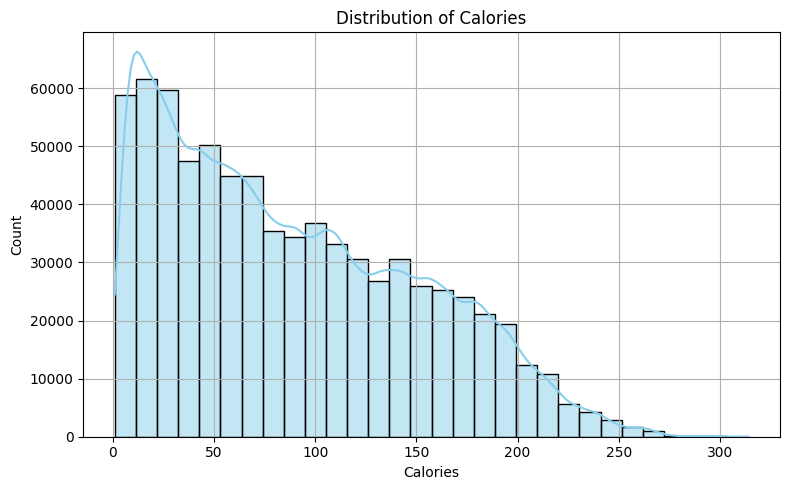

Skewness: 0.54


In [7]:
#target variable (right-skewed, RMSLE already accounts for skew, no need to log calories)
plt.figure(figsize = (8, 5))
sns.histplot(data =train, x = 'Calories', bins = 30, kde = True, stat = 'count', color = 'skyblue')
plt.xlabel('Calories')
plt.ylabel('Count')
plt.title('Distribution of Calories')
plt.grid(True)
plt.tight_layout()
plt.show()
print("Skewness:",round(train['Calories'].skew(),2))
#print("Most people burn low calories, but a few burn a lot (long right tail)")

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


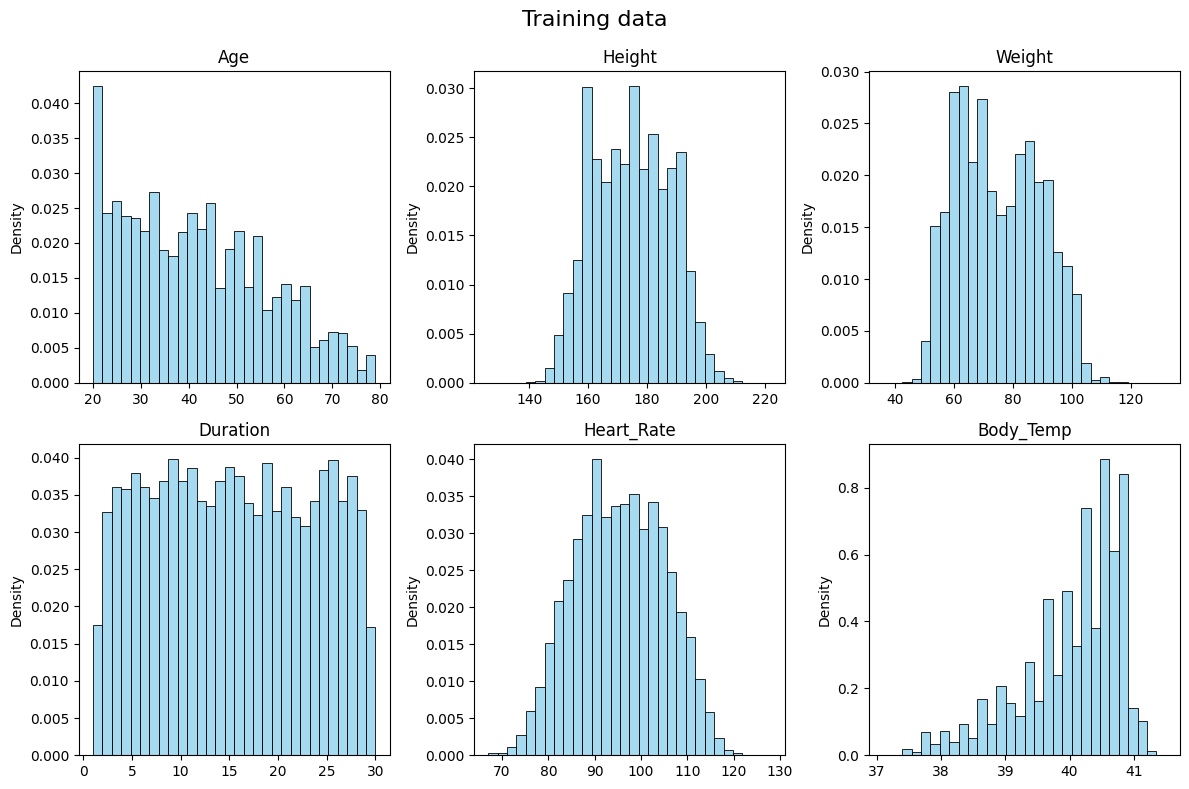

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


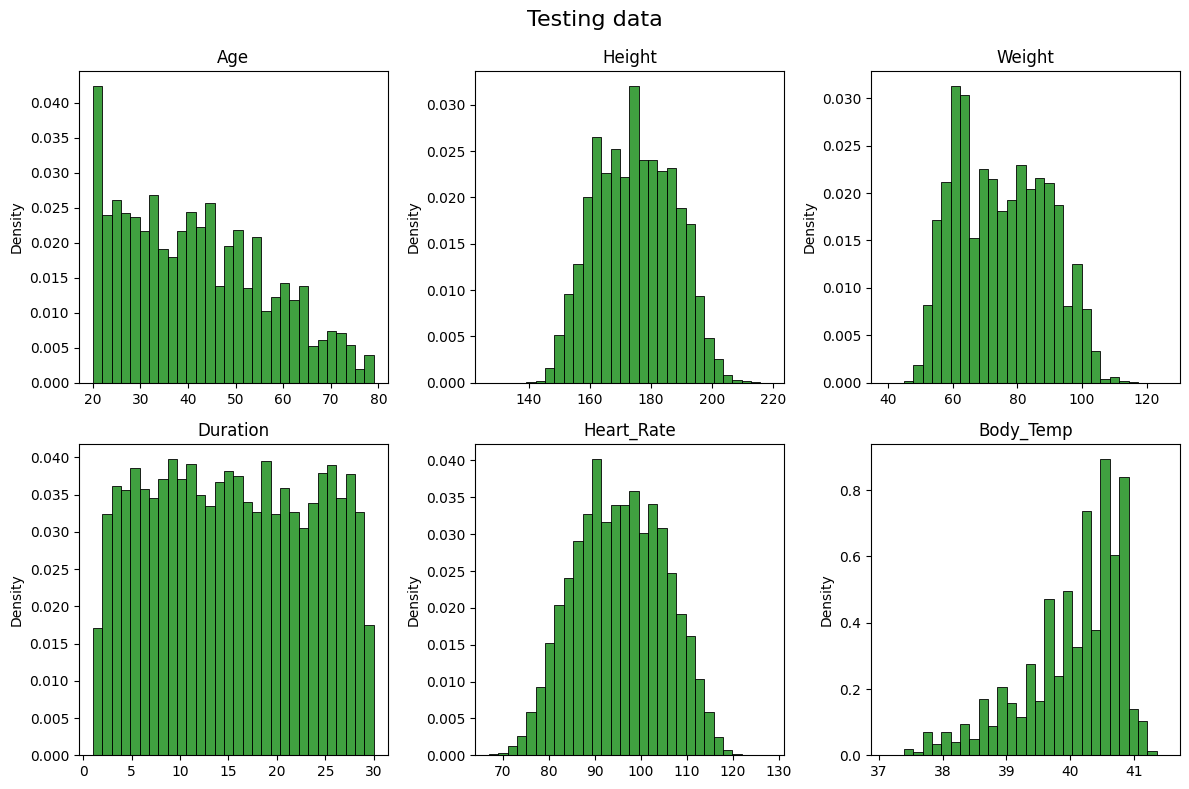

In [9]:
#Distribution for each variable (train vs test)
#list(train.columns)

def histogram_data(data, data_name = 'default', color = 'skyblue'):
    cols_to_plot = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    
    # Grid size
    n_cols = 3
    n_rows = -(-len(cols_to_plot) // n_cols)  # ceiling division
    
    # Set up the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    axes = axes.flatten()
    
    
    # Loop through each column and plot
    for i, col in enumerate(cols_to_plot):
        sns.histplot(data[col], ax=axes[i], bins=30, kde=False, color=color, stat='density')
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Density')
    
    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(data_name, fontsize=16)
    plt.show()

histogram_data(train, 'Training data')

histogram_data(test, 'Testing data', 'green')



use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

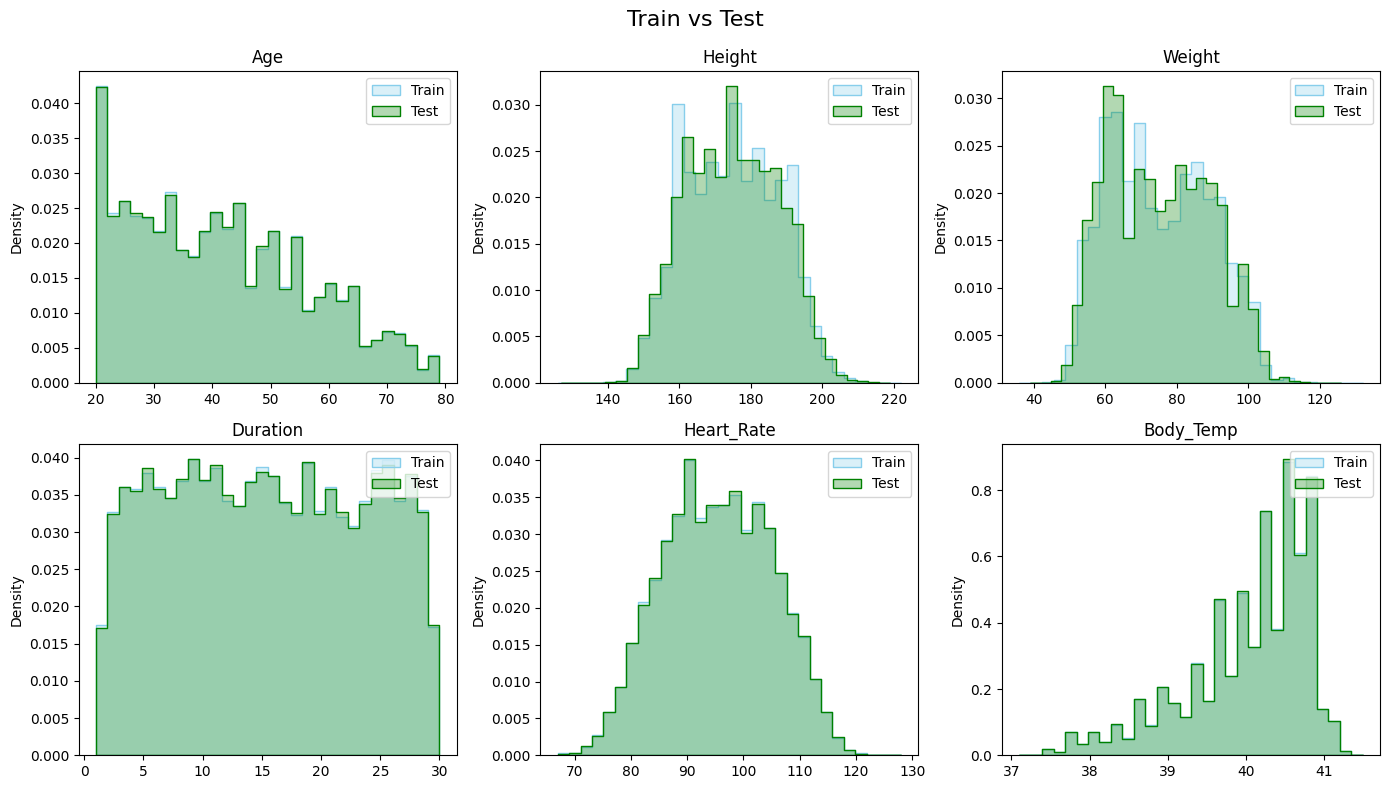

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def histogram_compare(train, test, data_name='Train vs Test'):
    cols_to_plot = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    
    # Grid size
    n_cols = 3
    n_rows = -(-len(cols_to_plot) // n_cols)  # ceiling division
    
    # Set up the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
    axes = axes.flatten()

    for i, col in enumerate(cols_to_plot):
        sns.histplot(train[col], ax=axes[i], bins=30, kde=False, stat='density', 
                     color='skyblue', label='Train', element='step', fill=True, alpha=0.3)
        sns.histplot(test[col], ax=axes[i], bins=30, kde=False, stat='density', 
                     color='green', label='Test', element='step', fill=True, alpha=0.3)

        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Density')
        axes[i].legend()

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(data_name, fontsize=16)
    plt.show()

# Call the new function
histogram_compare(train, test)


# Exploratory Analysis: Pearson Correlation coefficient

Before diving into data engineering, I conducted a Pearson correlation analysis to explore linear relationships between Calories and the independent variables. The results revealed that Duration, BodyTemperature, and HeartRate exhibit relatively strong positive correlations with Calories.

**This suggests that these variables may carry significant predictive power and should be prioritized during feature engineering and model development phases.**

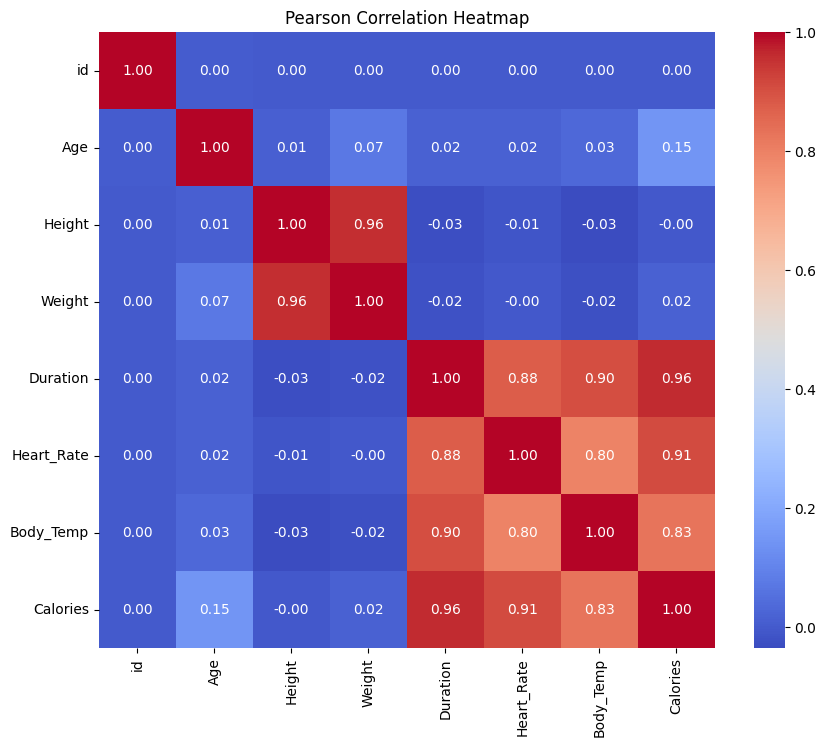

In [18]:
#find relationships between x and y (pearson correlation coefficient)
#High correlation wtih calories: duration, body temp, Heart rate
train_corr = train.drop('Sex', axis = 1)
corr = train_corr.corr(method = 'pearson')
plt.figure(figsize = (10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Pearson Correlation Heatmap')
plt.show()

# Categorical Feature Exploration: Sex and Calorie Distribution

Since Sex is a categorical variable, it is not suitable for Pearson correlation analysis, which requires continuous and normally distributed variables. To explore its relationship with Calories, I created a box plot to visualize the distribution of calorie expenditure across sexes.

The plot shows that males and females exhibit similar calorie distributions, with comparable medians and interquartile ranges. A few outliers are present in both groups, but overall, the variation appears consistent.

Although the direct influence of Sex on Calories may be limited, it can still offer indirect predictive value. For example, Sex can be incorporated into interaction terms with continuous variables (e.g., HeartRate × Sex) to capture subtle, group-specific patterns in calories expenditure.

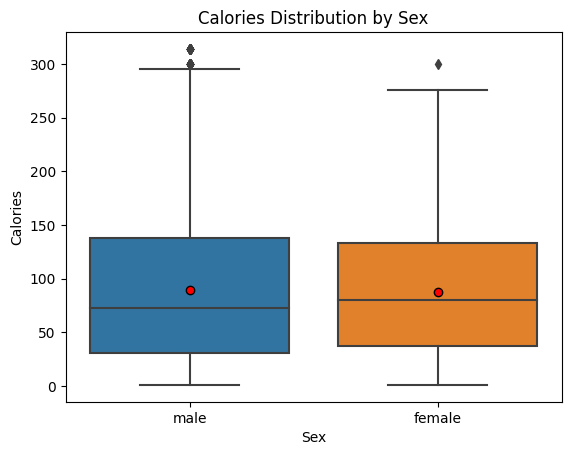

In [29]:
sns.boxplot(x='Sex', y='Calories', data=train, showmeans=True,
            meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"})
plt.title('Calories Distribution by Sex')
plt.show()




# Feature engineering

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

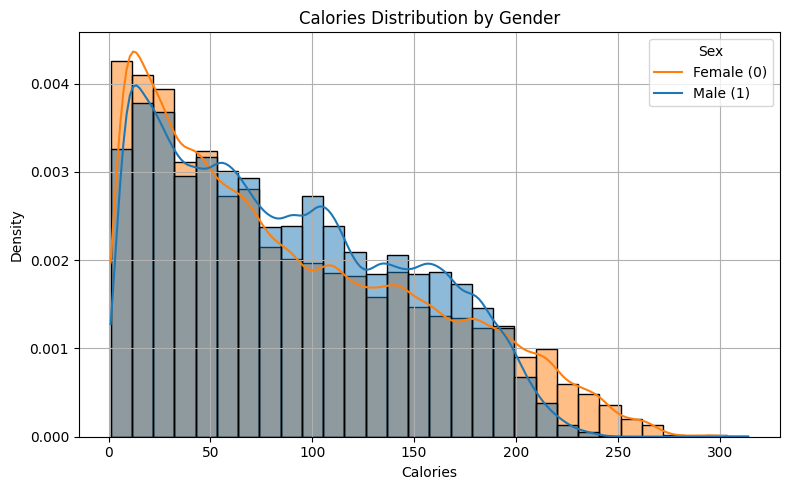

In [33]:
#pearson correlation coefficient (for sex, distribution of calories stratefied by sex)
plt.figure(figsize=(8, 5))
sns.histplot(data=train, x='Calories', hue='Sex_male', bins=30, stat='density', kde=True, alpha=0.5)

plt.title("Calories Distribution by Gender")
plt.xlabel("Calories")
plt.ylabel("Density")
plt.legend(title='Sex', labels=['Female (0)', 'Male (1)'])
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
#should collinearirt be considered in linear model only? how about tree-based model?
#examine collinearirty between variables, VIF
features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
X = train[features]
X = X.assign(Intercept=1)

#calculate VIF
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df = vif_df[vif_df['Variable'] != 'Intercept'].sort_values(by='VIF', ascending = False)
print(vif_df)

     Variable        VIF
2      Weight  12.766902
1      Height  12.702162
3    Duration   8.510592
5   Body_Temp   5.434871
4  Heart_Rate   4.285830
0         Age   1.050873


In [5]:

#train['Sex'] = train['Sex'].map({'male':1, 'female':0})
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

#estimated calories
train["e_Calories"] = np.where(
    train["Sex_male"] == 1,
    ((train['Age'] * 0.2017) - 
     (train['Weight'] * 0.09036) + 
     (train['Heart_Rate'] * 0.6309) - 55.0969) * train['Duration'] / 4.184,
    ((train['Age'] * 0.074) - 
     (train['Weight'] * 0.05741) + 
     (train['Heart_Rate'] * 0.4472) - 20.4022) * train['Duration'] / 4.184
    
)

test['e_Calories'] = np.where(
    test['Sex_male'] == 1,
    ((test['Age'] * 0.2017) - 
     (test['Weight'] * 0.09036) + 
     (test['Heart_Rate'] * 0.6309) - 55.0969) * test['Duration'] / 4.184,
    ((test['Age'] * 0.074) - 
     (test['Weight'] * 0.05741) + 
     (test['Heart_Rate'] * 0.4472) - 20.4022) * test['Duration'] / 4.184
)

train['BMI'] = train['Weight'] / ((train['Height'] / 100) ** 2)
test['BMI'] = test['Weight'] / ((test['Height'] / 100) ** 2)

#train['Difference'] = train['Calories'] - train['e_Calories']
#test['Difference'] = test['Calories'] - test['e_Calories']


train['HeartRate_Duration'] = train['Heart_Rate'] * train['Duration']
train['Weight_Duration'] = train['Weight'] * train['Duration']
train['Temp_HeartRate'] = train['Body_Temp'] * train['Heart_Rate']

train['Duration_squared'] = train['Duration'] ** 2
train['HeartRate_squared'] = train['Heart_Rate'] ** 2

train['log_Calories'] = np.log1p(train['Calories'])

# Interaction terms
test['HeartRate_Duration'] = test['Heart_Rate'] * test['Duration']
test['Weight_Duration'] = test['Weight'] * test['Duration']
test['Temp_HeartRate'] = test['Body_Temp'] * test['Heart_Rate']

# Polynomial (squared) terms
test['Duration_squared'] = test['Duration'] ** 2
test['HeartRate_squared'] = test['Heart_Rate'] ** 2


#men:Calories = ((Age * 0.2017) - (Weight * 0.09036) + (HeartRate * 0.6309) - 55.0969) * Duration / 4.184
#women:Calories = ((Age * 0.074) - (Weight * 0.05741) + (HeartRate * 0.4472) - 20.4022) * Duration / 4.184

train.head()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_male,e_Calories,BMI,HeartRate_Duration,Weight_Duration,Temp_HeartRate,Duration_squared,HeartRate_squared,log_Calories
0,0,36,189.0,82.0,26.0,101.0,41.0,150.0,True,52.669140,22.955684,2626.0,2132.0,4141.0,676.0,10201.0,5.017280
1,1,64,163.0,60.0,8.0,85.0,39.7,34.0,False,36.139962,22.582709,680.0,480.0,3374.5,64.0,7225.0,3.555348
2,2,51,161.0,64.0,7.0,84.0,39.8,29.0,False,28.880621,24.690405,588.0,448.0,3343.2,49.0,7056.0,3.401197
3,3,20,192.0,90.0,25.0,105.0,40.7,140.0,True,42.119981,24.414062,2625.0,2250.0,4273.5,625.0,11025.0,4.948760
4,4,38,166.0,61.0,25.0,102.0,40.6,146.0,False,146.523602,22.136740,2550.0,1525.0,4141.2,625.0,10404.0,4.990433


In [7]:
#feature interaction (No hidden clusters?)
# Features and target
features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Sex_male']
X = train[features]
y = train['Calories']

# Train model
model = lgb.LGBMRegressor(random_state=1)
model.fit(X, y)

# Create SHAP explainer
explainer = shap.Explainer(model)

# Compute SHAP values for the dataset
shap_values = explainer(X)
#shap.plots.beeswarm(shap_values)
shap_interactions = explainer.shap_interaction_values(X)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 7
[LightGBM] [Info] Start training from score 88.282781


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Calories', ylabel='Density'>

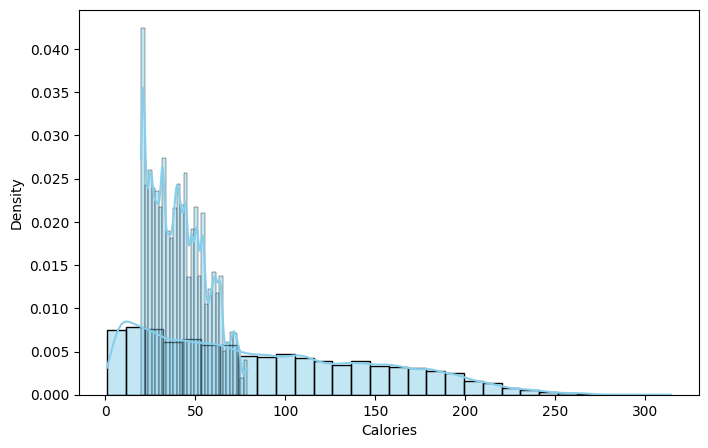

In [21]:
#PCA?
#key insight
#https://www.kaggle.com/competitions/playground-series-s5e5/discussion/578090


In [17]:
list(train.columns)

['id',
 'Age',
 'Height',
 'Weight',
 'Duration',
 'Heart_Rate',
 'Body_Temp',
 'Calories',
 'Sex_male',
 'e_Calories',
 'BMI',
 'HeartRate_Duration',
 'Weight_Duration',
 'Temp_HeartRate',
 'Duration_squared',
 'HeartRate_squared',
 'log_Calories']

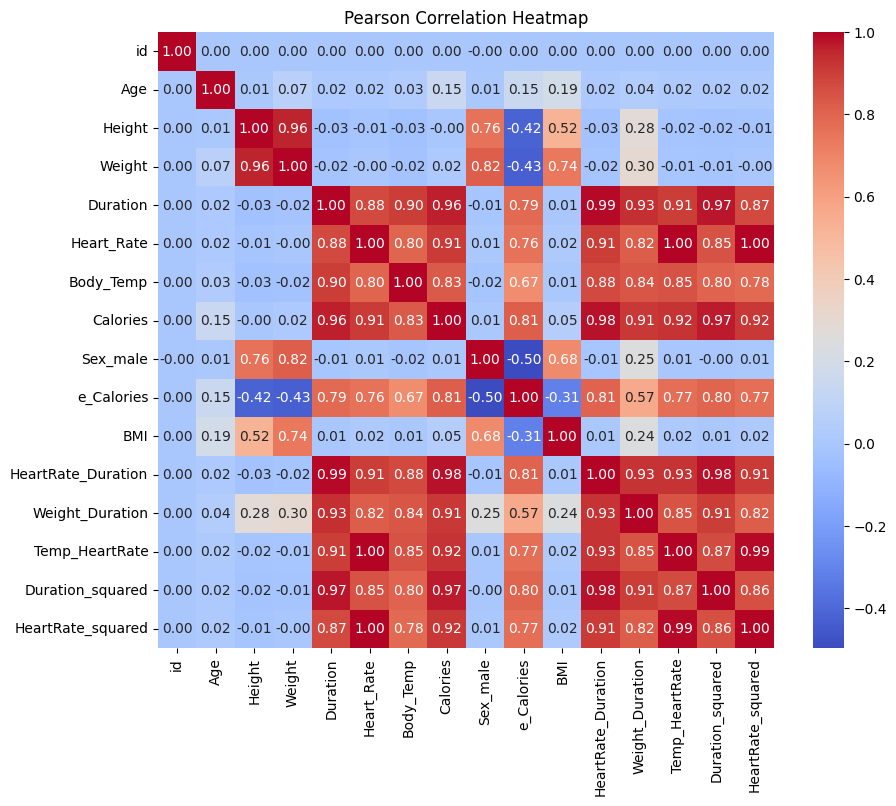

In [35]:
#find relationships between x and y (pearson correlation coefficient)
#High correlation wtih calories: duration, body temp, Heart rate
corr = train.corr(method = 'pearson')
plt.figure(figsize = (10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Pearson Correlation Heatmap')
plt.show()

# Set target and features

In [6]:
# Set predictor and response columns
X = train.drop(['id','Calories'], axis=1)
y = train['Calories']
X_test = test.drop('id', axis=1)


# Model trainig

In [47]:
#Linear regression
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X_test) #negative values?
y_pred = np.where(y_pred < 0, 1, y_pred)

In [8]:
lightgbm = lgb.LGBMRegressor(random_state=1)
lightgbm.fit(X,y)
y_pred = lightgbm.predict(X_test)
y_pred = np.where(y_pred<0,1, y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1726
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 14
[LightGBM] [Info] Start training from score 88.282781


In [9]:
test_ids = test['id']
submission = pd.DataFrame({
    'id': test_ids,
    'Calories': y_pred

})

#submission.describe()
submission.to_csv("/kaggle/working/submission.csv",index = False)


In [ ]:
#RF, lightgbm, xgboost, glm


# Initialize model
rf = RandomForestRegressor(random_state=1)

# Set hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': [1.0, 'sqrt']
}

# Grid search with 5-fold CV
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=5, #a fixed number of parameter combinations
                                   cv=5,
                                   scoring='neg_mean_squared_error',
                                   random_state=1,
                                   n_jobs=-1)

# Fit
random_search.fit(X, y)

# Predict
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


# Adding predictive result to the submission file

In [30]:
test_ids = test['Id']
submission = pd.DataFrame({
    'id': test_ids,
    'target': y_pred

})


In [51]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")
sub.head()
sub.dtypes

id            int64
Calories    float64
dtype: object

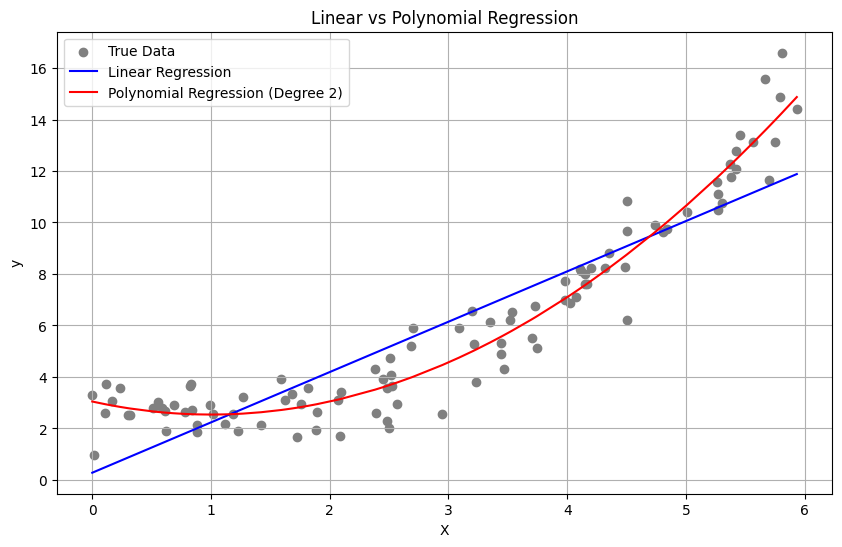

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 1. Generate synthetic nonlinear data
np.random.seed(1)
X = np.sort(6 * np.random.rand(100, 1), axis=0)
y = 0.5 * X**2 - X + 3 + np.random.randn(100, 1)

# 2. Fit Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred_linear = lin_reg.predict(X)

# 3. Fit Polynomial Regression (degree=2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)
y_pred_poly = poly_model.predict(X)

# 4. Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='gray', label='True Data')
plt.plot(X, y_pred_linear, color='blue', label='Linear Regression')
plt.plot(X, y_pred_poly, color='red', label='Polynomial Regression (Degree 2)')
plt.legend()
plt.title("Linear vs Polynomial Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.show()
